In [1]:
%matplotlib widget
%cd /data/seismo/kashyap/codes/p11-seismo-xl/data
from scipy.interpolate import interp1d
import sys
sys.path.append('/data/seismo/kashyap/codes/sun-intg')
%load_ext autoreload
%autoreload 2

/data/seismo/kashyap/codes/p11-seismo-xl/data
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def gaussian(x, mu, fwhm):
    """Returns a gaussian of chosen center and fwhm.

    Parameters
    ----------
    :x: range over which gaussian is defined
    :type: np.ndarray(ndim=1, dtype=float)

    :mu: center of the gaussian
    :type: float

    :fwhm: FWHM of the gaussian
    :type: float

    Returns
    -------
    :gn: gaussian profile
    :type: np.ndarray(ndim=1, dtype=float)
    """
    sigma = fwhm / np.sqrt(8. * np.log(2.))
    gn = np.exp(-(x-mu)**2/2./sigma/sigma)
    return gn


In [3]:
ts = fits.open('kplr008006161_kasoc-ts_slc_v1.fits')
ps = fits.open('kplr008006161_kasoc-psd_slc_v1.fits')

In [4]:
tsdata = ts[1].data # FLUX, TIME
psdata = ps[1].data # FREQUENCY, PSD

In [5]:
time = tsdata['TIME']
flux = tsdata['FLUX']
masknan = np.isnan(flux)
time = time[~masknan]
flux = flux[~masknan]

In [6]:
time = time - time[0] + 300
time_min = time[0]
time_max = time[-1]
dt = np.diff(time)
dt_uni = np.median(dt)
num_uni = int((time_max - time_min)/dt_uni)
time_uni = np.arange(num_uni)*dt_uni + time_min

In [7]:
f1d = interp1d(time, flux, fill_value=0., bounds_error=False)
flux_uni = f1d(time_uni)

Power spectrum estimated using linear interpolation is as good as the one provided by KASOC!


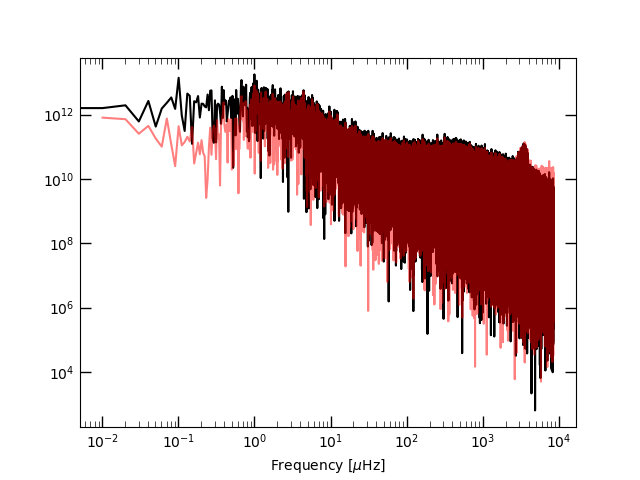

In [9]:
freq = np.fft.rfftfreq(len(time_uni), d=dt_uni*24*3600.)
powr = abs(np.fft.rfft(flux_uni))**2

fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True)
axs.loglog(freq*1e6, powr, 'k')
axs.loglog(psdata['FREQUENCY'], psdata['PSD']*1e10, 'r', alpha=0.5)
axs.set_xlabel('Frequency [$\\mu$Hz]')
#axs.set_xlim([2e3, 5e3])
print(f"Power spectrum estimated using linear interpolation is as good as the one provided by KASOC!")

In [17]:
plt.close('all')
ref_avg_len = 45
day2sec = 24*3600.
filter_mu = 3.5*1e-3
filter_fwhm = 2.5e-3
Navg = 2
Nshift = 1
NavgLength = Navg*ref_avg_len
NshiftLength = Nshift*ref_avg_len

# 1. Reading data from each quarter
# Note that the quarters are not sequentially arranged
# They need to be sorted first before combining continuous chunks for averaging
obs_days = time_uni[-1] - time_uni[0]
num_chunks = int(obs_days//NshiftLength)

avg_idx = int(NavgLength/(dt_uni))
if avg_idx%2==1: avg_idx += 1
shf_idx = int(NshiftLength/(dt_uni))
tstart_idx = 0
time_list = []
tmid_list = []
flux_list = []
pow_list = []
pow_list_gfilter = []
freq_list = []
ct_list = []
for idx in range(num_chunks):
    tend_idx = tstart_idx + avg_idx
    flux_chunk = flux_uni[tstart_idx:tend_idx]
    time_chunk = time_uni[tstart_idx:tend_idx]
    if len(time_chunk) < avg_idx:
        break
    time_list.append(time_chunk)
    flux_list.append(flux_chunk)
    tmid_list.append(time_chunk.mean())
    tstart_idx += shf_idx
    _fluxfft = np.fft.rfft(flux_chunk)
    sigpower = abs(_fluxfft)**2
    _freq = np.fft.rfftfreq(len(time_chunk), d=dt_uni*day2sec)
    gfilter = gaussian(_freq, filter_mu, filter_fwhm)
    pow_list.append(sigpower)
    pow_list_gfilter.append(sigpower*gfilter)
    freq_list.append(_freq)
    ct = np.fft.irfft(sigpower*gfilter)
    ct_list.append(ct)

pow_list_gfilter = np.array(pow_list_gfilter)
pow_ref = np.array(pow_list).mean(axis=0)
pow_gfilter_ref = pow_list_gfilter.mean(axis=0)
ct_list = np.array(ct_list)
ct_ref = ct_list.mean(axis=0)
pshapelist = [pow.shape[0] for pow in pow_list]
print(np.unique(pshapelist))

[66069]


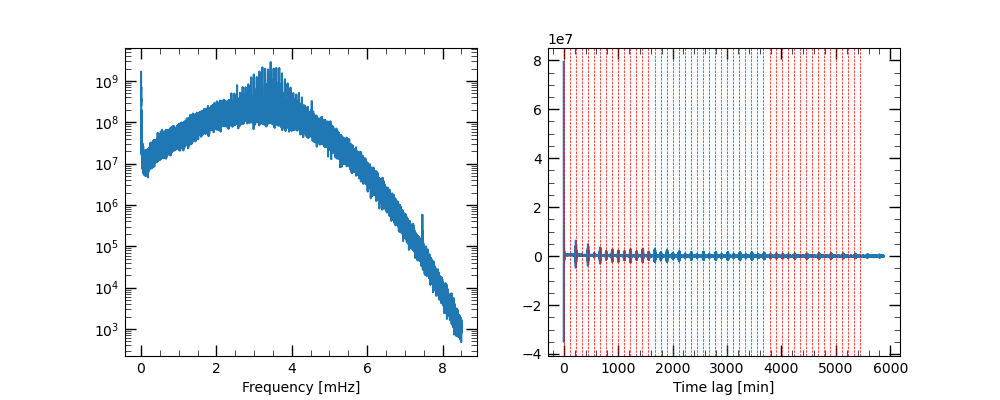

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axs[0].semilogy(freq_list[0]*1e3, pow_list_gfilter.mean(axis=0))
axs[0].set_xlabel('Frequency [mHz]')
maxT = 6000
SKIPDIFF = 111.2
axs[1].plot(np.arange(maxT)*dt_uni*24*60., ct_list.mean(axis=0)[:maxT])
axs[1].set_xlabel('Time lag [min]')
for idx in range(50):
    axs[1].axvline(x=SKIPDIFF*idx, color='red', linestyle='dashed', lw=0.5)
plt.show()

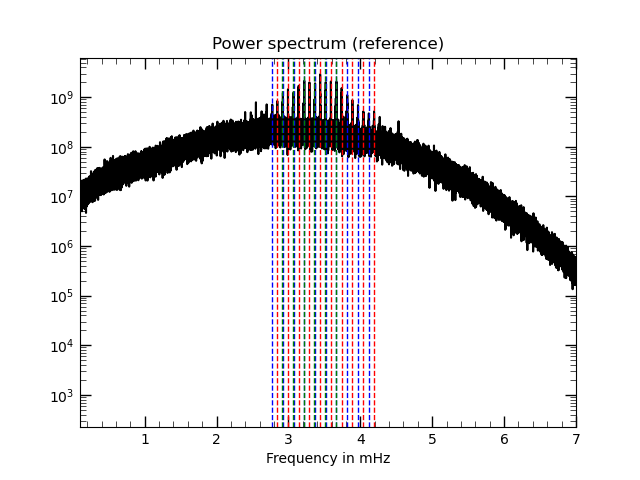

In [12]:
mode_params = np.loadtxt(f'/data/seismo/kashyap/codes/sun-intg/notebooks/KIC008006161.obs')
plt.figure()
plt.plot(freq_list[0]*1e3, pow_gfilter_ref, 'k')
plt.xlim([0.1, 7.])
for _idxp in range(mode_params.shape[0]):
    ell = mode_params[_idxp, 0]
    nu = mode_params[_idxp, 2]
    if ell==0: plt.axvline(x=nu*1e-3, color='blue', lw=1, linestyle='dashed')
    if ell==1: plt.axvline(x=nu*1e-3, color='red', lw=1, linestyle='dashed')
    if ell==2: plt.axvline(x=nu*1e-3, color='green', lw=1, linestyle='dashed')
plt.gca().set_yscale('log')
plt.xlabel('Frequency in mHz')
plt.title('Power spectrum (reference)')
plt.show()

In [27]:
from src.model.autocov import travelTime
f2pi = freq_list[0]*2*np.pi
dc0ref = np.fft.irfft(1j* f2pi * pow_gfilter_ref)
TT = travelTime(ct_ref, dc0ref, nskips=50, descstr='kic8006161', skipdiff=SKIPDIFF)

In [28]:
import pandas as pd
vdata = pd.read_csv('/data/seismo/kashyap/processed/vasileyv-8006161')

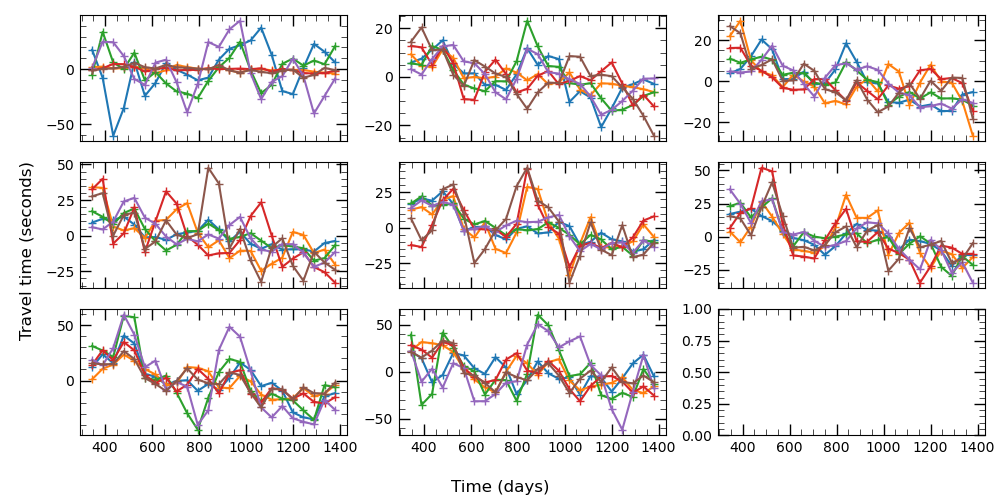

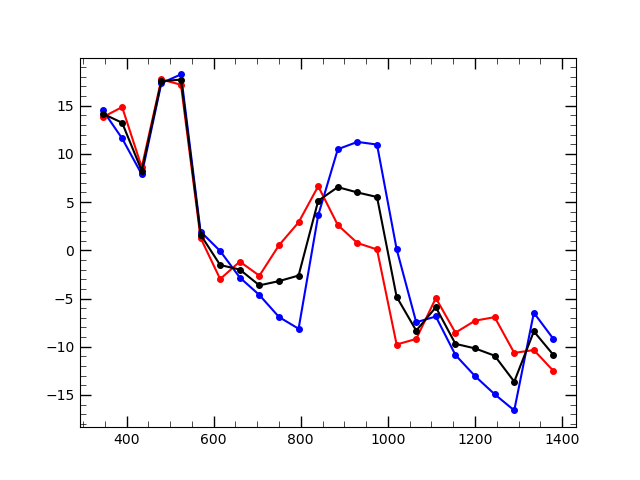

In [40]:
plt.close('all')
fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(10, 5))
axs = axs.flatten()

fig2, axs2 = plt.subplots()
epsilon = 1e-4
ct_epsilon = epsilon*ct_list + (1-epsilon)*ct_ref
tt_list = []
for idx in range(48):
    tt_list.append(np.array(TT.get_tt_chunks(ct_epsilon, idx))/epsilon)
    axs[int(idx//6)].plot(tmid_list, tt_list[-1], '+-')
    #axs[idx].set_title(f"Skip = {idx+1}", fontsize=10)
fig.supxlabel('Time (days)')
fig.supylabel('Travel time (seconds)')
tt_list = np.array(tt_list)
ignore_skip = [1, 3, 5, 18, 20, 24]
skip_list = np.arange(tt_list.shape[0])+1
skip_mask = np.ones_like(skip_list, dtype='bool')
#for isp in ignore_skip: skip_mask[isp-1] = False
tt_mean = tt_list[skip_mask, :].mean(axis=0)
tt0mean = tt_list[0::2].mean(axis=0)
tt1mean = tt_list[1::2].mean(axis=0)
axs2.plot(tmid_list, tt0mean, 'o-b', markersize=4)
axs2.plot(tmid_list, tt1mean, 'o-r', markersize=4)
axs2.plot(tmid_list, tt_mean, 'o-k', markersize=4)
    
fig.tight_layout()

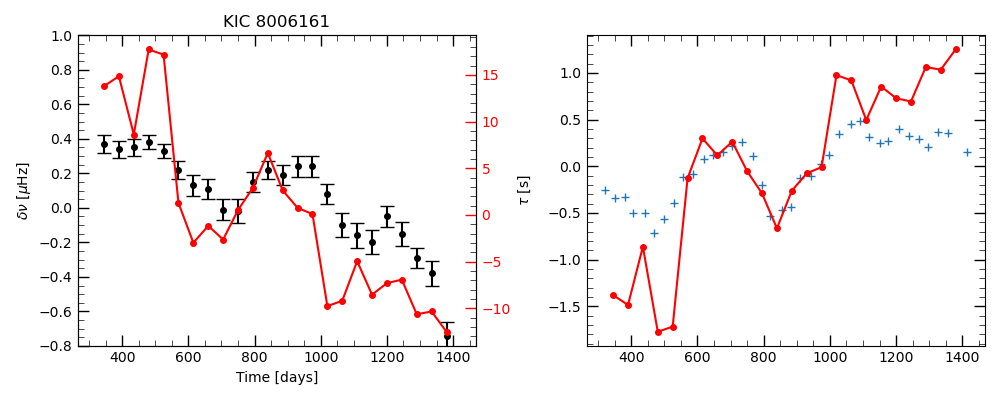

In [30]:
#plt.close('all')
modefit_data = pd.read_csv('/data/seismo/kashyap/codes/p11-seismo-xl/data/8006161.csv')
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(10, 4))
axs[0].errorbar(modefit_data['time'], -modefit_data['delnu'],  yerr=modefit_data['delnu_error'],  capsize=5, color='k', marker='o', markersize=4, linestyle='')
axs[0].set_ylim([-0.8, 1.])
taxs = axs[0].twinx()
axs[1].plot(vdata['x'].values, vdata[' y'].values, '+')
axs[1].plot(np.array(tmid_list), -tt1mean*0.1, 'o-r', markersize=4)
taxs.plot(np.array(tmid_list), tt1mean, 'o-r', markersize=4)
taxs.tick_params(axis='y', colors='red')
axs[0].set_ylabel('$\\delta\\nu$ [$\\mu$Hz]')
taxs.set_ylabel('$\\tau$ [s]')
axs[0].set_xlabel('Time [days]')
axs[0].set_title('KIC 8006161')
fig.tight_layout()